In [1]:
import pandas as pd

In [2]:
datambg = pd.read_csv("datalabel/mbglabel.csv")

In [3]:
datambg2 = pd.read_csv("datalabel/mbg2label.csv")

In [4]:
datasarc = pd.read_csv("datalabel/sarcasticlabel.csv")

In [5]:
datatrainmix = pd.concat([datambg, datambg2, datasarc], ignore_index=True)

In [6]:
datatrainmix.isna().sum()

steming_data    2
Sentiment       0
dtype: int64

In [7]:
datatrainmix.dropna(subset=['steming_data'], inplace=True)

In [8]:
datatrainmix.isna().sum()

steming_data    0
Sentiment       0
dtype: int64

In [9]:
datatrainmix.head()

,steming_data,Sentiment
0,makan siang gratis mending,Positif
1,bela mbak bias sekolah makan siang gratis pas ...,Positif
2,anggar dituruninnya ngopernya blog ya dicicipi...,Positif
3,karyawan industri cikarang makan siang jemput ...,Positif
4,ambil abang ya makan siang gratis ya abang rol...,Positif


## ***Bidirectional LSTM with SMOTE***

In [28]:
import pandas as pd
import numpy as np
from collections import Counter
import tensorflow as tf

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [30]:
X = datatrainmix['steming_data'].astype(str) 
y = datatrainmix['numbered_category']

In [31]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

In [32]:
max_length = datatrainmix['steming_data'].apply(len).max()
max_length

1174

In [33]:
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [34]:
vocab_size = len(tokenizer.word_index) + 1

In [35]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [38]:
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_train_pad.shape

(8862, 1174)

In [39]:
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad.shape

(2216, 1174)

In [40]:
smote = SMOTE(random_state=42)

In [41]:
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pad, y_train)

In [42]:
sorted(Counter(y_train_resampled).items())

[(0, 5638), (1, 5638), (2, 5638)]

In [43]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred_labels, sample_weight)
        self.recall.update_state(y_true, y_pred_labels, sample_weight)
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [44]:
model = Sequential([
    Input(shape=(max_length,)),
    Embedding(input_dim=vocab_size, output_dim=32), # <-- EMBEDDING SEKARANG 32
    Bidirectional(LSTM(32, return_sequences=False, dropout=0.5, recurrent_dropout=0.3)),
    Dropout(0.5),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(3, activation='softmax')  
])

In [45]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy', F1Score()])

In [46]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 1174, 32)       │       425,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 442,819 (1.69 MB)

 Trainable params: 442,819 (1.69 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [48]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=5e-4)

In [49]:
history = model.fit(
    X_train_resampled, y_train_resampled,
    validation_data=(X_val_pad, y_val),
    epochs=25, 
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 178s 326ms/step - accuracy: 0.4443 - f1_score: 0.7157 - loss: 1.1463 - val_accuracy: 0.6232 - val_f1_score: 0.6399 - val_loss: 0.9332 - learning_rate: 0.0010
Epoch 2/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 194s 366ms/step - accuracy: 0.6087 - f1_score: 0.8549 - loss: 0.8369 - val_accuracy: 0.5916 - val_f1_score: 0.6667 - val_loss: 1.0879 - learning_rate: 0.0010
Epoch 3/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 187s 353ms/step - accuracy: 0.6600 - f1_score: 0.8886 - loss: 0.7485 - val_accuracy: 0.6196 - val_f1_score: 0.6887 - val_loss: 1.0762 - learning_rate: 0.0010
Epoch 4/25
529/529 ━━━━━━━━━━━━━━━━━━━━ 197s 344ms/step - accuracy: 0.7032 - f1_score: 0.9154 - loss: 0.6840 - val_accuracy: 0.6160 - val_f1_score: 0.6941 - val_loss: 1.1559 - learning_rate: 5.0000e-04


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val_pad)

y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_val.values

class_names = ['Negatif', 'Netral', 'Positif']
labels_ordered = [1, 2, 0]

# Cetak Laporan Klasifikasi
print("Laporan Klasifikasi Bidirectional LSTM dengan SMOTE:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names, labels=labels_ordered))

70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step
Laporan Klasifikasi Bidirectional LSTM dengan SMOTE:

              precision    recall  f1-score   support

     Negatif       0.45      0.66      0.54       467
      Netral       0.21      0.17      0.19       339
     Positif       0.81      0.72      0.76      1410

    accuracy                           0.62      2216
   macro avg       0.49      0.52      0.50      2216
weighted avg       0.64      0.62      0.63      2216



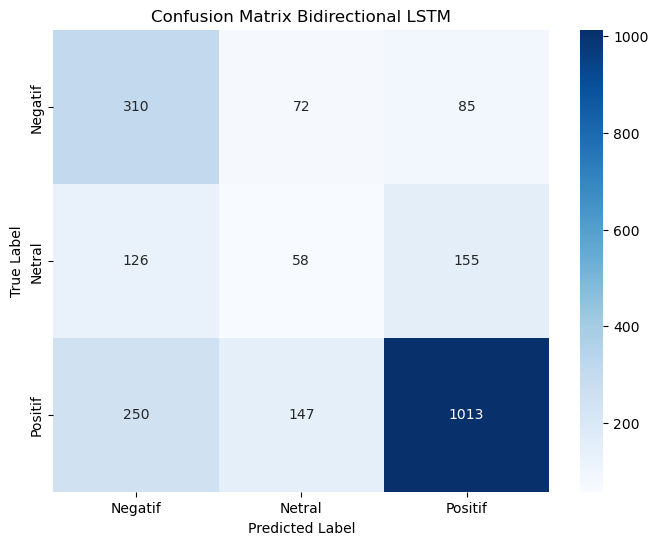

In [52]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes, labels=labels_ordered)

# Tampilkan heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix Bidirectional LSTM')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

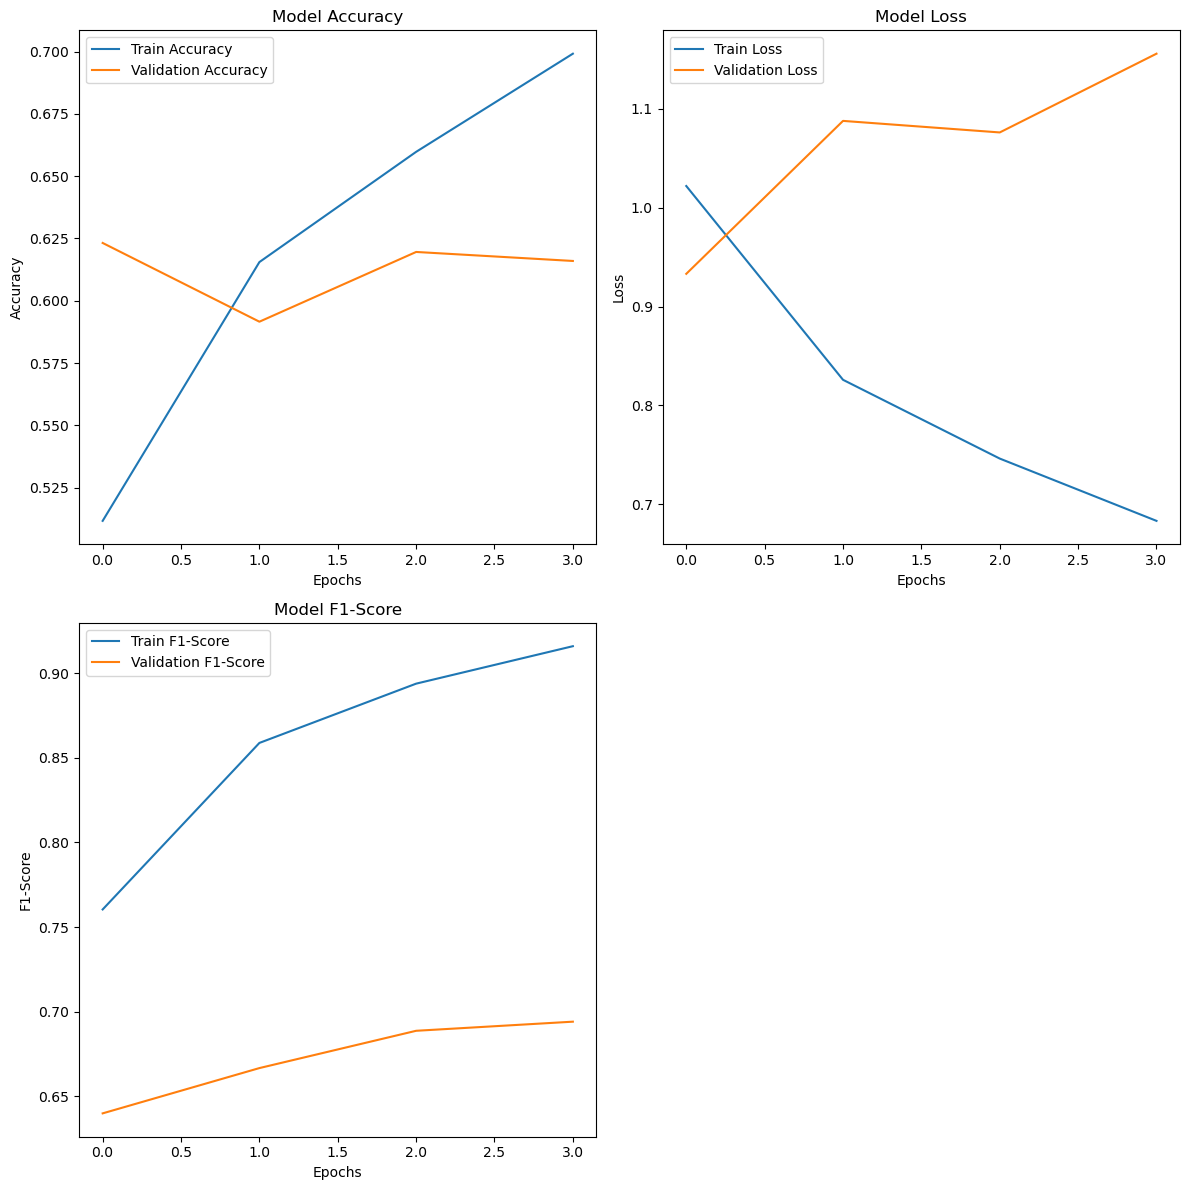

In [54]:
import matplotlib.pyplot as plt

# Plot the training and validation metrics
plt.figure(figsize=(12, 12))

# Plot Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot F1-Score
plt.subplot(2, 2, 3)
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('Model F1-Score')
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [55]:
# Save the model in SavedModel format
model.save('bidirectional_lstm/bidirectional_lstmsmote_model.h5')